In [96]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [97]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps):
    # 计算移动方差元平方根的倒数
    inv = tf.cast(tf.math.rsqrt(moving_var + eps), X.dtype)
    # 缩放和移位
    inv *= gamma
    Y = X * inv + (beta - moving_mean * inv)
    return Y


In [98]:
class BatchNorm(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)

    def build(self, input_shape):
        weight_shape = [input_shape[-1], ]
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = self.add_weight(name='gamma', shape=weight_shape,
            initializer=tf.initializers.ones, trainable=True)
        self.beta = self.add_weight(name='beta', shape=weight_shape,
            initializer=tf.initializers.zeros, trainable=True)
        # 非模型参数的变量初始化为0和1
        self.moving_mean = self.add_weight(name='moving_mean',
            shape=weight_shape, initializer=tf.initializers.zeros,
            trainable=False)
        self.moving_variance = self.add_weight(name='moving_variance',
            shape=weight_shape, initializer=tf.initializers.ones,
            trainable=False)
        super(BatchNorm, self).build(input_shape)

    def assign_moving_average(self, variable, value):
        momentum = 0.9
        delta = variable * momentum + value * (1 - momentum)
        return variable.assign(delta)

    @tf.function
    def call(self, inputs, training=True):
        if training:
            axes = list(range(len(inputs.shape) - 1))
            batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
            batch_variance = tf.reduce_mean(tf.math.squared_difference(
                inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
            
            batch_mean = tf.squeeze(batch_mean, axes)
            batch_variance = tf.squeeze(batch_variance, axes)
            
            mean_update = self.assign_moving_average(
                self.moving_mean, batch_mean)
            
            variance_update = self.assign_moving_average(
              self.moving_variance, batch_variance)
            
            #self.add_update(mean_update)
            #self.add_update(variance_update)
            mean, variance = batch_mean, batch_variance
        else:
            mean, variance = self.moving_mean, self.moving_variance
        output = batch_norm(inputs, moving_mean=mean, moving_var=variance,
            beta=self.beta, gamma=self.gamma, eps=1e-5)
        
        return output

In [99]:
# 回想一下，这个函数必须传递给d2l.train_ch6。
# 或者说为了利用我们现有的CPU/GPU设备，需要在strategy.scope()建立模型
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5,
                               input_shape=(28, 28, 1)),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(84),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(10)]
    )

loss 0.468, train acc 0.831, test acc 0.746
35742.3 examples/sec on /GPU:0


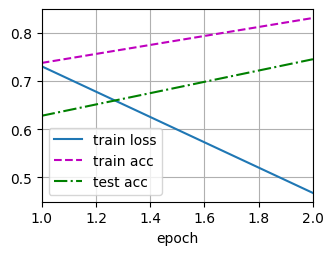

In [100]:
lr, num_epochs, batch_size = 1.0, 2, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
net = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())